loading dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LpIOo51TriziCYxqzIZw")
project = rf.workspace("test-hmoom").project("cleaning_bot_dataset_2.0")
version = project.version(3)
dataset = version.download("voc")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cleaning_bot_dataset_2.0-3 in voc:: 100%|██████████| 5335/5335 [00:01<00:00, 4775.25it/s]


imports

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as et
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten
import shutil
import json
from google.colab import files
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
import random
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix



In [3]:
def rename_folder(folder_path, new_name):
    # Get the directory containing the folder
    parent_dir = os.path.dirname(folder_path)

    # Create the new path with the new folder name
    new_folder_path = os.path.join(parent_dir, new_name)

    # Rename the folder
    os.rename(folder_path, new_folder_path)

    print(f"Folder renamed from {folder_path} to {new_folder_path}")

# Find all matching folders using glob function
folder_paths = glob('/content/cleaning_bot_dataset_2.0-*')

if folder_paths:
    folder_path = folder_paths[0]  # Use the first match
    new_folder_name = 'cleaning_bot_object_dataset'  # New folder name
    rename_folder(folder_path, new_folder_name)
else:
    print("No matching folders found.")

Folder renamed from /content/cleaning_bot_dataset_2.0-3 to /content/cleaning_bot_object_dataset


splitting dataset into separate images and xml folders

In [4]:
def move_files_by_extension(source_directory, target_directory, file_extension):
    # Ensure the target directory exists (create it if it doesn't)
    os.makedirs(target_directory, exist_ok=True)

    # Walk through the source directory and its subdirectories
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            # Check if the file has the specified extension
            if file.endswith(file_extension):
                # Create full path for source and destination
                source_path = os.path.join(root, file)
                target_path = os.path.join(target_directory, file)

                # Move the file
                shutil.move(source_path, target_path)
                print(f"Moved: {source_path} to {target_path}")

def organize_files(folder_name):
    # Define source and target directories based on the folder name
    source_directory = os.path.join("/content/cleaning_bot_object_dataset/", folder_name)
    xml_target_directory = os.path.join(source_directory, "xmls")
    images_target_directory = os.path.join(source_directory, "images")

    # Create target directories if they don't exist
    os.makedirs(xml_target_directory, exist_ok=True)
    os.makedirs(images_target_directory, exist_ok=True)

    # Move XML files
    move_files_by_extension(source_directory, xml_target_directory, ".xml")

    # Move JPG files
    move_files_by_extension(source_directory, images_target_directory, ".jpg")

organize_files("test")
organize_files("train")
organize_files("valid")


Streaming output truncated to the last 5000 lines.
Moved: /content/cleaning_bot_object_dataset/train/WhatsApp-Image-2024-07-05-at-16-49-33_jpeg_jpg.rf.19c050730e7d6eeff00161cad08df985.jpg to /content/cleaning_bot_object_dataset/train/images/WhatsApp-Image-2024-07-05-at-16-49-33_jpeg_jpg.rf.19c050730e7d6eeff00161cad08df985.jpg
Moved: /content/cleaning_bot_object_dataset/train/augmented_1009_frame360_jpg.rf.39a7b1524091231a75b4001b7a8ae1d5.jpg to /content/cleaning_bot_object_dataset/train/images/augmented_1009_frame360_jpg.rf.39a7b1524091231a75b4001b7a8ae1d5.jpg
Moved: /content/cleaning_bot_object_dataset/train/23_jpg.rf.15f48eeea374d121c02f9f4b24e9f111.jpg to /content/cleaning_bot_object_dataset/train/images/23_jpg.rf.15f48eeea374d121c02f9f4b24e9f111.jpg
Moved: /content/cleaning_bot_object_dataset/train/dogs28_jpg.rf.70866a54eeaf383961cf14d4437c7bec.jpg to /content/cleaning_bot_object_dataset/train/images/dogs28_jpg.rf.70866a54eeaf383961cf14d4437c7bec.jpg
Moved: /content/cleaning_bot_ob

combine train, valid, test to process together and split later after preprocessing

In [5]:
# Define the source directories
source_dirs = ['/content/cleaning_bot_object_dataset/train', '/content/cleaning_bot_object_dataset/valid', '/content/cleaning_bot_object_dataset/test']

# Define the destination directory
destination_dir = '/content/cleaning_bot_object_dataset'
xml_dest_dir = os.path.join(destination_dir, 'xmls')
jpg_dest_dir = os.path.join(destination_dir, 'images')

# Create the destination directories if they do not exist
os.makedirs(xml_dest_dir, exist_ok=True)
os.makedirs(jpg_dest_dir, exist_ok=True)

# Copy XML and JPG files from source directories to destination directories
for src_dir in source_dirs:
    xml_src_dir = os.path.join(src_dir, 'xmls')
    jpg_src_dir = os.path.join(src_dir, 'images')

    # Copy XML files
    for filename in os.listdir(xml_src_dir):
        src_file = os.path.join(xml_src_dir, filename)
        dest_file = os.path.join(xml_dest_dir, filename)
        shutil.copy(src_file, dest_file)

    # Copy JPG files
    for filename in os.listdir(jpg_src_dir):
        src_file = os.path.join(jpg_src_dir, filename)
        dest_file = os.path.join(jpg_dest_dir, filename)
        shutil.copy(src_file, dest_file)

print("Files have been successfully combined.")


Files have been successfully combined.


In [6]:
def delete_folder(folder_path):

    if os.path.exists(folder_path):
        # Remove the folder and all its contents
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and all its contents have been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [7]:
folder_to_delete = '/content/cleaning_bot_object_dataset/train'
delete_folder(folder_to_delete)

folder_to_delete = '/content/cleaning_bot_object_dataset/valid'
delete_folder(folder_to_delete)

folder_to_delete = '/content/cleaning_bot_object_dataset/test'
delete_folder(folder_to_delete)

Folder '/content/cleaning_bot_object_dataset/train' and all its contents have been deleted.
Folder '/content/cleaning_bot_object_dataset/valid' and all its contents have been deleted.
Folder '/content/cleaning_bot_object_dataset/test' and all its contents have been deleted.


In [8]:
def count_files_in_folder(folder_path):
    # List all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return len(files)

folder_path = '/content/cleaning_bot_object_dataset/xmls'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")

folder_path = '/content/cleaning_bot_object_dataset/images'
file_count = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")


Number of files in '/content/cleaning_bot_object_dataset/xmls': 2666
Number of files in '/content/cleaning_bot_object_dataset/images': 2666


build xml parser

In [9]:
def parse_annotation(xml_file):
    tree = et.parse(xml_file)
    root = tree.getroot()

    annotation = {
        'filename': root.find('filename').text,
        'size': {
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'depth': int(root.find('size/depth').text),
        },
        'objects': []
    }

    for obj in root.findall('object'):
        obj_data = {
            'name': obj.find('name').text,
            'bndbox': {
                'xmin': int(obj.find('bndbox/xmin').text),
                'xmax': int(obj.find('bndbox/xmax').text),
                'ymin': int(obj.find('bndbox/ymin').text),
                'ymax': int(obj.find('bndbox/ymax').text),
            },
            'polygon': []
        }

        for i in range(1, 60):  # Assuming no more than 60 points in a polygon
            x = obj.find(f'polygon/x{i}')
            y = obj.find(f'polygon/y{i}')
            if x is not None and y is not None:
                obj_data['polygon'].append((float(x.text), float(y.text)))
            else:
                break

        annotation['objects'].append(obj_data)

    return annotation


In [10]:
# Specify the folder path
folder_path = '/content/cleaning_bot_object_dataset/xmls'

# Get a list of files in the folder
files = os.listdir(folder_path)

# Choose a random file
random_file = random.choice(files)

# Get the full path of the chosen file
xml_file = os.path.join(folder_path, random_file)
# xml_file = '/content/cleaning_bot_object_dataset/xmls/standing_8_11_23-71-_jpg.rf.ee430e8bb392e115f304698468892cad.xml'

parsed_data = parse_annotation(xml_file)

# Pretty-print the parsed data
print(json.dumps(parsed_data, indent=4))

{
    "filename": "cats_73_jpg.rf.1ed833394d793b90fe964fb1bf23c8ce.jpg",
    "size": {
        "width": 299,
        "height": 299,
        "depth": 3
    },
    "objects": [
        {
            "name": "pet",
            "bndbox": {
                "xmin": 33,
                "xmax": 252,
                "ymin": 1,
                "ymax": 300
            },
            "polygon": []
        }
    ]
}


find data distribution by parsing xmls

In [11]:
def parse_annotations_for_classes(xml_folder):
    """
    Parses annotation XML files and extracts labels.

    Args:
    xml_folder: Path to the folder containing XML files

    Returns:
    A list of labels extracted from the XML files
    """
    labels = []

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            tree = et.parse(os.path.join(xml_folder, xml_file))
            root = tree.getroot()

            for obj in root.findall('object'):
                label = obj.find('name').text
                # Filter out any non-relevant labels (e.g., if label is not empty)
                if label.strip():  # Make sure it's not an empty string or just whitespace
                    labels.append(label)

    return labels

def count_labels(labels):
    """
    Counts occurrences of each label.

    Args:
    labels: A list of labels

    Returns:
    A pandas DataFrame with counts of each label
    """
    label_counts = Counter(labels)
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])
    label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return label_df

# Define paths
xml_folder_path = '/content/cleaning_bot_object_dataset/xmls'

# Parse annotations and count labels
labels = parse_annotations_for_classes(xml_folder_path)
label_distribution = count_labels(labels)

# Print the output
print(label_distribution)


         Label  Count
0        waste   1921
1  home_object   1789
2          pet    625
3       person    573
4        spill    427
5         dirt     74


In [12]:
# label_mapping = {
#     'clothes': 0,
#     'dust_debris': 1,
#     'electronics': 2,
#     'furniture': 3,
#     'household_item': 4,
#     'liquid_spill': 5,
#     'person': 6,
#     'pet': 7,
#     'small_objects': 8,
#     'waste': 9
# }

# define label mapping
label_mapping = {label: idx for idx, label in enumerate(label_distribution['Label'].unique())}

num_classes = len(label_mapping)
print('total classes = ', num_classes)
# label_mapping['null'] = total_classes + 1
print(label_mapping)

# Reverse the label_mapping dictionary to map numbers to names
reverse_label_mapping = {v: k for k, v in label_mapping.items()}


total classes =  6
{'waste': 0, 'home_object': 1, 'pet': 2, 'person': 3, 'spill': 4, 'dirt': 5}


Data Preprocessing

create list of all parsed xml annotation data

In [13]:
# Get all XML file paths
xml_files = sorted(glob('/content/cleaning_bot_object_dataset/xmls/*.xml'))
image_folder = '/content/cleaning_bot_object_dataset/images/'  # Path to the images folder

y = []  # List to store the targets

# Loop over each file path and parse it
for xml_file in xml_files:
    tree = et.parse(xml_file)
    root = tree.getroot()

    # Find the object element
    obj = root.find('object')

    if obj is not None:
        label_obj = obj.find('name').text

        # Get label from the mapping
        label = label_mapping.get(label_obj)

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        # Append the results to our target list
        y.append([label, xmin, ymin, xmax, ymax])
    else:
        # Determine the corresponding image file (same name as XML file, but with .jpg extension)
        base_name = os.path.basename(xml_file).replace('.xml', '')
        image_file = os.path.join(image_folder, f"{base_name}.jpg")

        # Delete both the XML and the corresponding image file
        if os.path.exists(xml_file):
            os.remove(xml_file)
            print(f"Deleted XML: {xml_file}")
        if os.path.exists(image_file):
            os.remove(image_file)
            print(f"Deleted Image: {image_file}")


Deleted XML: /content/cleaning_bot_object_dataset/xmls/IMG_2744_png.rf.17340c9fba12229026bf8ff1196a0b3f.xml
Deleted Image: /content/cleaning_bot_object_dataset/images/IMG_2744_png.rf.17340c9fba12229026bf8ff1196a0b3f.jpg


In [14]:
print(y[random.randint(0, file_count)])

[4, 29, 158, 102, 193]


create list of all images associated to xml files

In [15]:
x = []  # List to store the images

# Get all image paths
images_path = sorted(glob('/content/cleaning_bot_object_dataset/images/*.jpg'))

# Loop over image paths
for image_path in images_path:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    x.append(img_rgb)

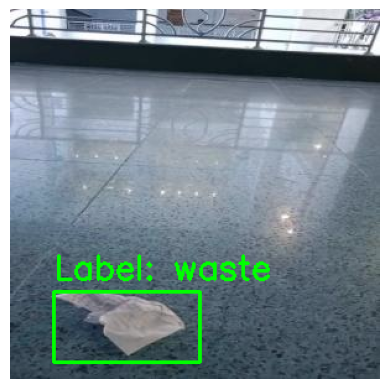

Raw image array shape: (299, 299, 3)
Bounding box coordinates: [35, 228, 153, 285]
Label: 0 (waste)
Label Mapping: {'waste': 0, 'home_object': 1, 'pet': 2, 'person': 3, 'spill': 4, 'dirt': 5}


In [16]:
# Ensure file_count is the length of x
file_count = len(x)

# Extract random image and the corresponding bounding box coordinates
num = random.randint(0, file_count - 1)  # Adjusted to prevent out-of-bounds error
img_example = x[num]
bbox = y[num][1:]  # Bounding box coordinates from the first annotation
label = y[num][0]  # The label of the image
label_name = reverse_label_mapping[label]

def visualize_image_with_bbox(img, bbox, label, label_name):
    # Draw the bounding box on the image
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(img, 'Label: {}'.format(label_name), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # Print raw data for inspection
    print(f"Raw image array shape: {img.shape}")
    print(f"Bounding box coordinates: {bbox}")
    print(f"Label: {label} ({label_name})")
    print("Label Mapping:", label_mapping)

# Visualize the image with the bounding box
visualize_image_with_bbox(img_example, bbox, label, label_name)


split into train, test numpy arrays

In [17]:
# Convert lists to NumPy arrays
x = np.array(x)  # Convert list of images to numpy array
y = np.array(y)  # Convert list of labels to numpy array

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

# Check the shapes of the split data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2132, 299, 299, 3)
x_test shape: (533, 299, 299, 3)
y_train shape: (2132, 5)
y_test shape: (533, 5)


In [18]:
# Assuming y is structured as [label, xmin, ymin, xmax, ymax]
labels = [entry[0] for entry in y]  # Extracting only the class labels
label_counts = Counter(labels)

print("Label counts:", label_counts)
print("Total samples in y:", len(y))


Label counts: Counter({np.int64(1): 816, np.int64(0): 747, np.int64(2): 403, np.int64(3): 349, np.int64(4): 300, np.int64(5): 50})
Total samples in y: 2665


split data into separate categorical and boundary box sectors

In [19]:
categ_train = y_train[:, 0]  # Take the first column for training categories
categ_test = y_test[:, 0]    # Take the first column for testing categories
bbox_train = y_train[:, 1:]   # Take the remaining columns for training bounding boxes
bbox_test = y_test[:, 1:]     # Take the remaining columns for testing bounding boxes

# Print shapes to verify
print(f"categ_train shape: {categ_train.shape}")
print(f"categ_test shape: {categ_test.shape}")
print(f"bbox_train shape: {bbox_train.shape}")
print(f"bbox_test shape: {bbox_test.shape}")

# Convert category labels to one-hot encoded vectors
categ_train = tf.keras.utils.to_categorical(categ_train.astype(int), num_classes=num_classes)
categ_test = tf.keras.utils.to_categorical(categ_test.astype(int), num_classes=num_classes)

# Print shapes after one-hot encoding
print(f"One-hot encoded categ_train shape: {categ_train.shape}")
print(f"One-hot encoded categ_test shape: {categ_test.shape}")

categ_train shape: (2132,)
categ_test shape: (533,)
bbox_train shape: (2132, 4)
bbox_test shape: (533, 4)
One-hot encoded categ_train shape: (2132, 6)
One-hot encoded categ_test shape: (533, 6)


Loading the Inception V3 model with custom layers

---



In [20]:
# Constants
input_shape = (299, 299, 3)
learning_rate_initial = 1e-4  # Initial learning rate

# Load InceptionV3 with pre-trained ImageNet weights, excluding the top layers
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Get the output of the 'mixed10' layer
last_layer = inception.get_layer('mixed10').output

# Add custom layers
x = Flatten()(last_layer)  # Flatten the output from 'mixed10'
x = Dropout(0.2)(x)  # Regularization to reduce overfitting
x = Dense(512, activation="relu")(x)  # Dense layer with ReLU activation
x = Dropout(0.2)(x)  # Another Dropout layer

# Output layers: Classification and Bounding Box Regression
classification_output = Dense(num_classes, activation='softmax', name='classification')(x)
bounding_box_output = Dense(4, activation='linear', name='bounding_box')(x)

# Create the final model with InceptionV3 inputs and two outputs
model = Model(inputs=inception.inputs, outputs=[classification_output, bounding_box_output])

# Compile the model with optimizer, losses, and metrics
model.compile(
    optimizer=Adam(learning_rate=learning_rate_initial),
    loss={
        'classification': 'categorical_crossentropy',  # Classification task
        'bounding_box': 'mse'  # Bounding box regression task
    },
    metrics={
        'classification': 'accuracy',  # Track classification accuracy
        'bounding_box': 'mse'  # Track Mean Squared Error for bounding boxes
    }
)

# Display the model architecture
model.summary()

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 42:
        return float(lr)  # Keep learning rate constant for first 42 epochs
    else:
        return float(lr * tf.math.exp(-0.12))  # Exponential decay of learning rate

# Define callbacks
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)  # Learning rate scheduler

# Specify the path where you want to save the model
checkpoint_path = '/content/models/best_model.keras'

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # or 'val_accuracy' depending on your metric of interest
    save_best_only=True,
    mode='min',  # or 'max' if you're monitoring accuracy
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# TensorBoard for visualization
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')  # Logs for TensorBoard visualization


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 88,917,290 (339.19 MB)

 Trainable params: 88,882,858 (339.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

Model Training

In [21]:
r = model.fit(
    x_train,  # Training images
    [categ_train, bbox_train],  # Classification and bounding box labels
    epochs=100,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(x_test, [categ_test, bbox_test]),  # Validation data
    callbacks=[callback_lr, checkpoint_callback, early_stopping, tensorboard],  # Callbacks for dynamic LR, saving, early stopping, and TensorBoard
    verbose=1  # Show training progress
)

Epoch 1/100


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - bounding_box_loss: 8231.2637 - bounding_box_mse: 8231.4258 - classification_accuracy: 0.1538 - classification_loss: 18.4852 - loss: 8249.9092   
Epoch 1: val_loss improved from inf to 2181.60303, saving model to /content/models/best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - bounding_box_loss: 8172.5337 - bounding_box_mse: 8172.8516 - classification_accuracy: 0.1544 - classification_loss: 18.4729 - loss: 8191.3242 - val_bounding_box_loss: 2189.3806 - val_bounding_box_mse: 2178.4966 - val_classification_accuracy: 0.3865 - val_classification_loss: 3.1190 - val_loss: 2181.6030 - learning_rate: 1.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - bounding_box_loss: 1384.9711 - bounding_box_mse: 1384.9331 - classification_accuracy: 0.2601 - classification_loss: 13.4133 - loss: 1398.3466
Epoch 2: val_loss improved from 2181.60303 to 1929.49121, saving model to /content/models/best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 677ms

In [22]:
results = pd.DataFrame(r.history)
results.tail()

,bounding_box_loss,bounding_box_mse,classification_accuracy,classification_loss,loss,val_bounding_box_loss,val_bounding_box_mse,val_classification_accuracy,val_classification_loss,val_loss,learning_rate
29,209.365463,208.448425,0.780957,2.000206,210.452850,1046.771118,1053.675293,0.960600,0.145691,1053.822632,0.0001
30,216.579468,216.569321,0.779081,2.092460,218.668411,984.526306,990.101196,0.971857,0.128483,990.229736,0.0001
31,221.507507,220.888916,0.778612,2.158646,223.048401,1044.358398,1051.156372,0.966229,0.155084,1051.311523,0.0001
32,212.691040,211.983459,0.805347,1.818584,213.767517,1058.831055,1065.206787,0.968105,0.149822,1065.355103,0.0001
33,201.961823,202.261597,0.797842,1.734632,203.976151,1000.818848,1002.304321,0.958724,0.178360,1002.476990,0.0001


In [23]:
results.columns

Index(['bounding_box_loss', 'bounding_box_mse', 'classification_accuracy',
       'classification_loss', 'loss', 'val_bounding_box_loss',
       'val_bounding_box_mse', 'val_classification_accuracy',
       'val_classification_loss', 'val_loss', 'learning_rate'],
      dtype='object')

In [24]:
# Save the results DataFrame as an Excel file
results.to_excel("model_results.xlsx", index=False)

In [26]:
# Load the results DataFrame from an Excel file
file_path = '/content/model_results.xlsx'  # Change this to your file path
df = pd.read_excel(file_path)

# Create an 'epoch' column starting from 1
df['epoch'] = df.index + 1  # Adding 1 to start epochs from 1

# Select rows for every 5 epochs
milestone_epochs = df.iloc[::5]  # Every 5th row (which corresponds to every 5th epoch)

# Display the selected milestone epochs
print(milestone_epochs)

# If you want to save this to a new Excel file
milestone_epochs.to_excel('milestone_epochs.xlsx', index=False)


    bounding_box_loss  bounding_box_mse  classification_accuracy  \
0         4237.600098       4248.419434                 0.196529   
5          434.428223        433.935455                 0.454503   
10         324.481323        323.867310                 0.595216   
15         291.434540        291.670166                 0.677298   
20         249.223465        248.724319                 0.741088   
25         237.733231        237.706696                 0.765478   
30         216.579468        216.569321                 0.779081   

    classification_loss         loss  val_bounding_box_loss  \
0             17.645159  4266.093262            2189.380615   
5              7.857334   441.807159            1325.547729   
10             5.070992   328.941132            1144.918945   
15             3.786875   295.447296            1097.494751   
20             2.863633   251.591110            1030.201294   
25             2.520810   240.230881            1031.682251   
30            

Visualizing Results

In [27]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

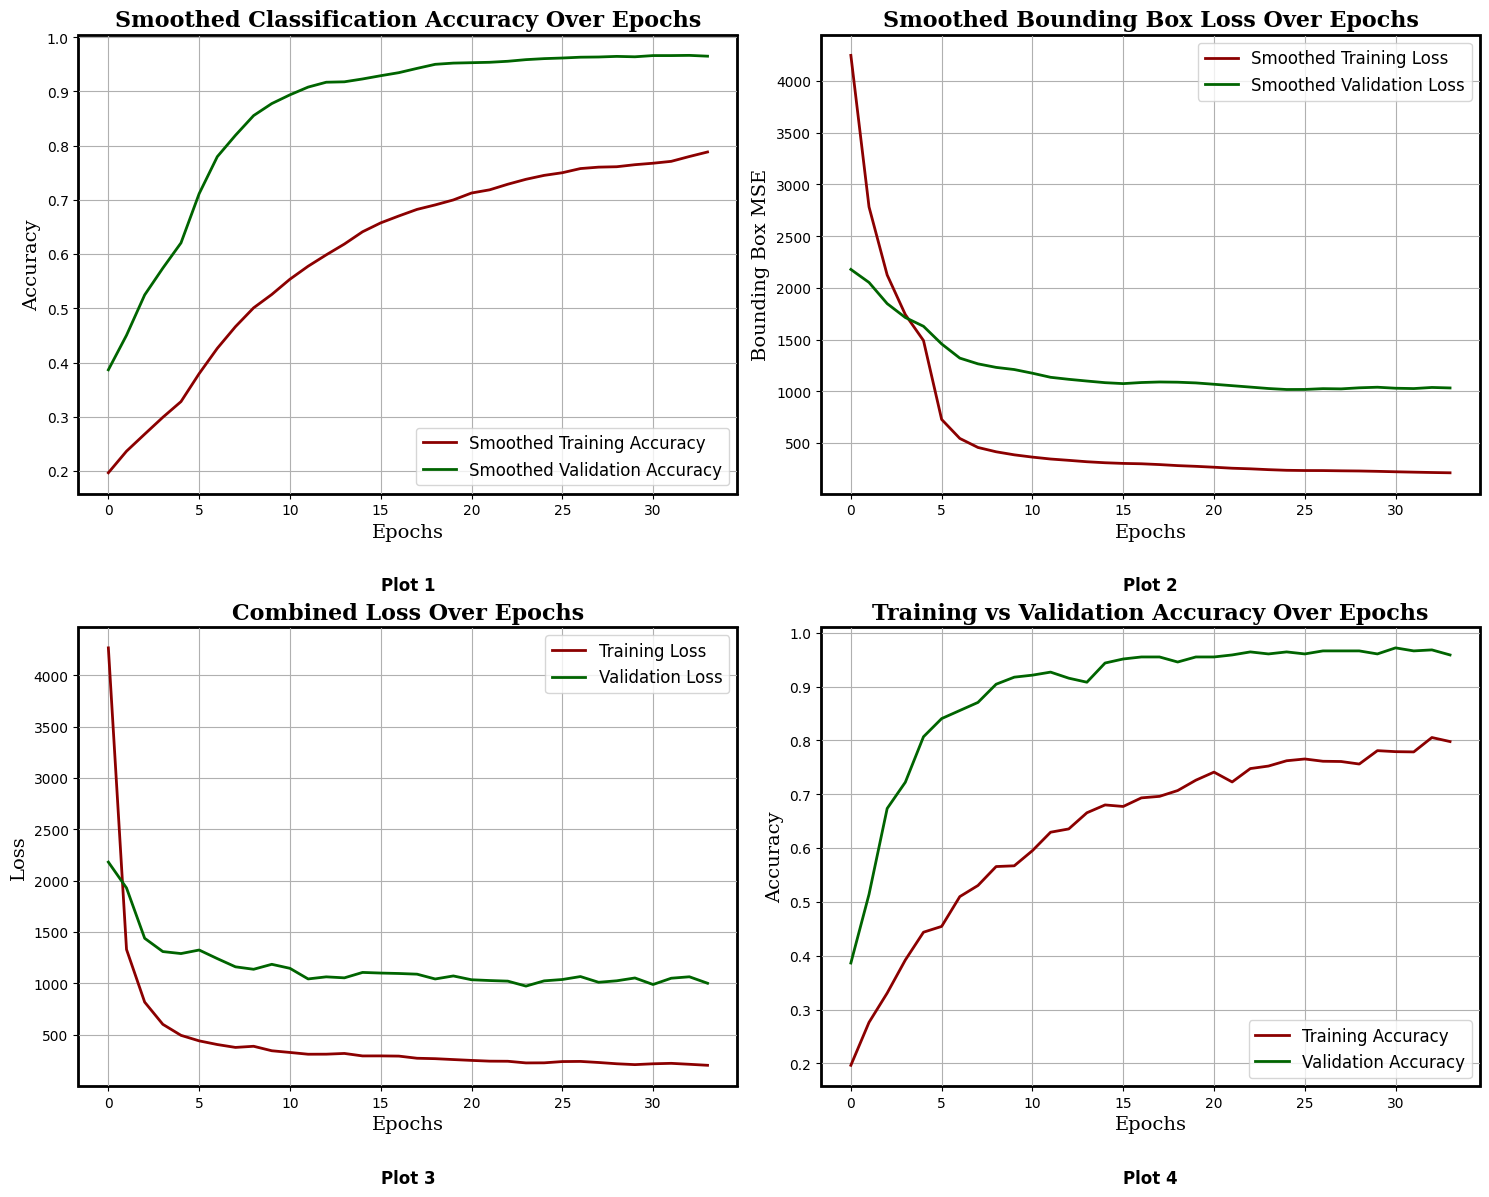

In [28]:
# Load the data from the Excel file
file_path = '/content/model_results.xlsx'  # Update with your file path
results = pd.read_excel(file_path)

# Smoothing function (moving average)
def smooth(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

# Add smoothed columns to the results dataframe
results['smooth_classification_accuracy'] = smooth(results['classification_accuracy'])
results['smooth_val_classification_accuracy'] = smooth(results['val_classification_accuracy'])
results['smooth_bounding_box_mse'] = smooth(results['bounding_box_mse'])
results['smooth_val_bounding_box_mse'] = smooth(results['val_bounding_box_mse'])

# Create a figure with 2 rows and 2 columns for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid of plots

# Define a function to add a border to the subplots
def add_border(ax):
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(2)

# 1. Smoothed Classification Accuracy
axes[0, 0].plot(results['smooth_classification_accuracy'], label='Smoothed Training Accuracy', color='#8B0000', linewidth=2)
axes[0, 0].plot(results['smooth_val_classification_accuracy'], label='Smoothed Validation Accuracy', color='#006400', linewidth=2)
axes[0, 0].set_title('Smoothed Classification Accuracy Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[0, 0].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[0, 0].set_ylabel('Accuracy', fontsize=14, fontname='DejaVu Serif')
axes[0, 0].legend(loc='best', fontsize=12)
axes[0, 0].grid(True)
add_border(axes[0, 0])
axes[0, 0].text(0.5, -0.2, 'Plot 1', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[0, 0].transAxes)

# 2. Smoothed Bounding Box Loss
axes[0, 1].plot(results['smooth_bounding_box_mse'], label='Smoothed Training Loss', color='#8B0000', linewidth=2)
axes[0, 1].plot(results['smooth_val_bounding_box_mse'], label='Smoothed Validation Loss', color='#006400', linewidth=2)
axes[0, 1].set_title('Smoothed Bounding Box Loss Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[0, 1].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[0, 1].set_ylabel('Bounding Box MSE', fontsize=14, fontname='DejaVu Serif')
axes[0, 1].legend(loc='best', fontsize=12)
axes[0, 1].grid(True)
add_border(axes[0, 1])
axes[0, 1].text(0.5, -0.2, 'Plot 2', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[0, 1].transAxes)

# 3. Combined Loss
axes[1, 0].plot(results['loss'], label='Training Loss', color='#8B0000', linewidth=2)
axes[1, 0].plot(results['val_loss'], label='Validation Loss', color='#006400', linewidth=2)
axes[1, 0].set_title('Combined Loss Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[1, 0].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[1, 0].set_ylabel('Loss', fontsize=14, fontname='DejaVu Serif')
axes[1, 0].legend(loc='best', fontsize=12)
axes[1, 0].grid(True)
add_border(axes[1, 0])
axes[1, 0].text(0.5, -0.2, 'Plot 3', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[1, 0].transAxes)

# 4. Training vs Validation Accuracy
axes[1, 1].plot(results['classification_accuracy'], label='Training Accuracy', color='#8B0000', linewidth=2)
axes[1, 1].plot(results['val_classification_accuracy'], label='Validation Accuracy', color='#006400', linewidth=2)
axes[1, 1].set_title('Training vs Validation Accuracy Over Epochs', fontsize=16, fontweight='bold', fontname='DejaVu Serif')
axes[1, 1].set_xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
axes[1, 1].set_ylabel('Accuracy', fontsize=14, fontname='DejaVu Serif')
axes[1, 1].legend(loc='best', fontsize=12)
axes[1, 1].grid(True)
add_border(axes[1, 1])
axes[1, 1].text(0.5, -0.2, 'Plot 4', ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[1, 1].transAxes)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the entire figure
plt.show()


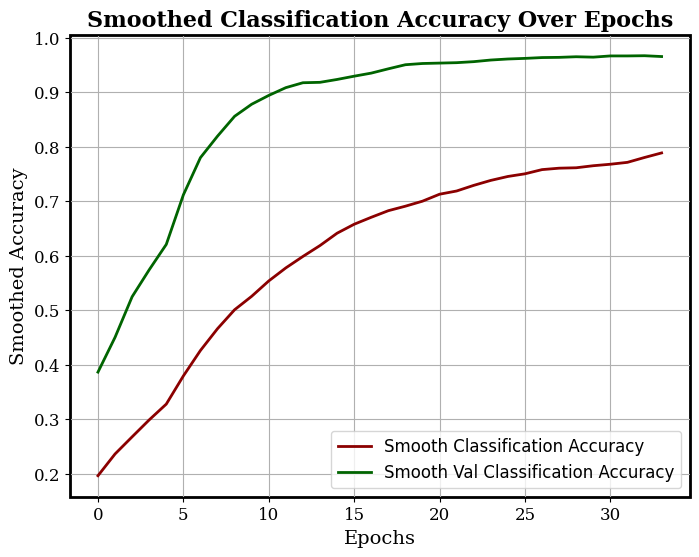

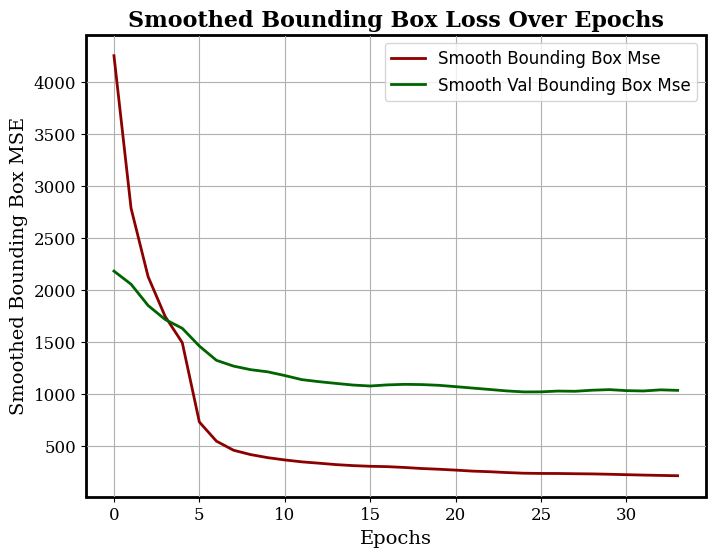

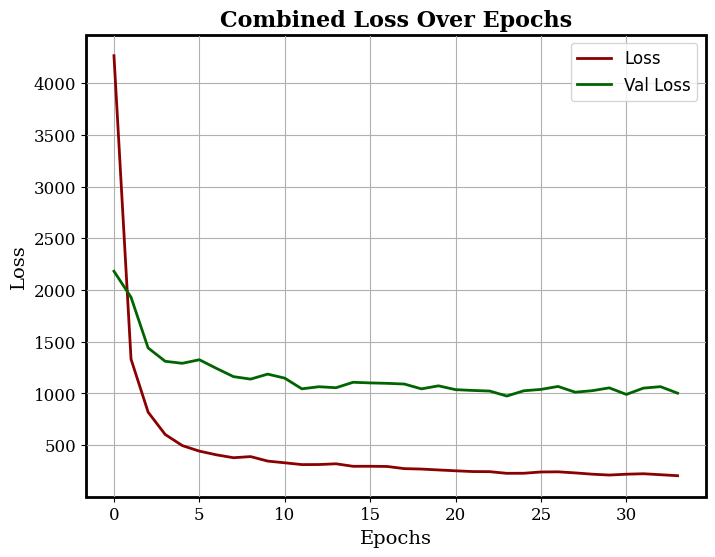

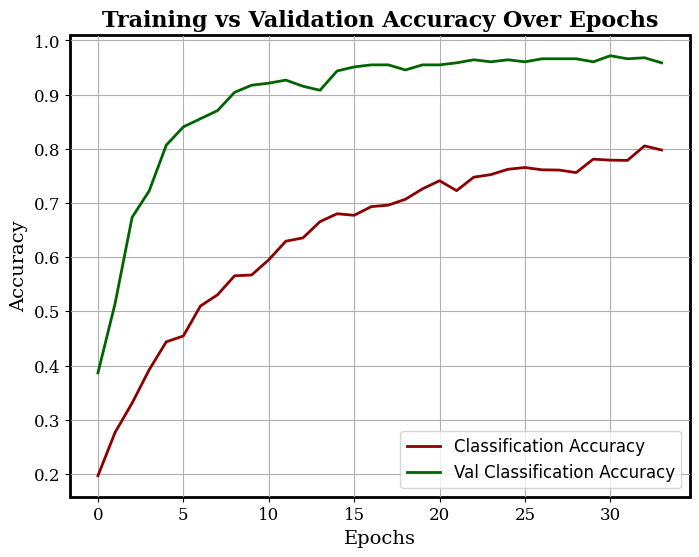

In [29]:
# Smoothing function (moving average)
def smooth(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

# Add smoothed columns to the results dataframe
results['smooth_classification_accuracy'] = smooth(results['classification_accuracy'])
results['smooth_val_classification_accuracy'] = smooth(results['val_classification_accuracy'])
results['smooth_bounding_box_mse'] = smooth(results['bounding_box_mse'])
results['smooth_val_bounding_box_mse'] = smooth(results['val_bounding_box_mse'])

# Function to plot with borders, consistent style, and formatting
def plot_metric(results, y_values, title, y_label, colors=['#8B0000', '#006400']):  # Dark Red and Dark Green
    plt.figure(figsize=(8, 6))

    # Plot each value with the provided colors
    for i, y in enumerate(y_values):
        plt.plot(results[y], label=y.replace('_', ' ').title(), color=colors[i], linewidth=2)

    # Add title, labels, and grid
    plt.title(title, fontsize=16, fontweight='bold', fontname='DejaVu Serif')
    plt.xlabel('Epochs', fontsize=14, fontname='DejaVu Serif')
    plt.ylabel(y_label, fontsize=14, fontname='DejaVu Serif')

    # Set tick labels font
    plt.xticks(fontsize=12, fontname='DejaVu Serif')
    plt.yticks(fontsize=12, fontname='DejaVu Serif')

    # Add a legend with the best location
    plt.legend(loc='best', fontsize=12)

    # Add a grid for clarity
    plt.grid(True)

    # Add a rectangle border around the whole plot (including labels and title)
    plt.gca().patch.set_edgecolor('black')
    plt.gca().patch.set_linewidth(2)

    # Set white background
    plt.gca().set_facecolor('white')

    # Show the plot
    plt.show()

# Smoothed Classification Accuracy
plot_metric(results,
            ['smooth_classification_accuracy', 'smooth_val_classification_accuracy'],
            'Smoothed Classification Accuracy Over Epochs',
            'Smoothed Accuracy')

# Smoothed Bounding Box Loss
plot_metric(results,
            ['smooth_bounding_box_mse', 'smooth_val_bounding_box_mse'],
            'Smoothed Bounding Box Loss Over Epochs',
            'Smoothed Bounding Box MSE')

# Combined Loss Over Epochs (no smoothing needed)
plot_metric(results,
            ['loss', 'val_loss'],
            'Combined Loss Over Epochs',
            'Loss')

# Training vs Validation Accuracy (unsmoothed)
plot_metric(results,
            ['classification_accuracy', 'val_classification_accuracy'],
            'Training vs Validation Accuracy Over Epochs',
            'Accuracy')


In [30]:
# Load the results DataFrame from an Excel file
file_path = '/content/model_results.xlsx'  # Change this to your file path
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to understand its structure
print(df.columns)

# Create an 'epoch' column starting from 1
df['epoch'] = df.index + 1  # Adding 1 to start epochs from 1

# Select rows for every 5 epochs
milestone_epochs = df.iloc[::5]  # Every 5th row (which corresponds to every 5th epoch)

# Display the selected milestone epochs
print(milestone_epochs)

# If you want to save this to a new Excel file
milestone_epochs.to_excel('milestone_epochs.xlsx', index=False)


Index(['bounding_box_loss', 'bounding_box_mse', 'classification_accuracy',
       'classification_loss', 'loss', 'val_bounding_box_loss',
       'val_bounding_box_mse', 'val_classification_accuracy',
       'val_classification_loss', 'val_loss', 'learning_rate'],
      dtype='object')
    bounding_box_loss  bounding_box_mse  classification_accuracy  \
0         4237.600098       4248.419434                 0.196529   
5          434.428223        433.935455                 0.454503   
10         324.481323        323.867310                 0.595216   
15         291.434540        291.670166                 0.677298   
20         249.223465        248.724319                 0.741088   
25         237.733231        237.706696                 0.765478   
30         216.579468        216.569321                 0.779081   

    classification_loss         loss  val_bounding_box_loss  \
0             17.645159  4266.093262            2189.380615   
5              7.857334   441.807159       

testing the model



In [32]:
model_path = '/content/models/best_model.keras'
model = tf.keras.models.load_model(model_path)

In [33]:
def load_image(path):
    """Load an image from a given path."""
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image from {path}")
    return image

def predict_random_xml_and_image(xml_folder, image_folder, model):
    """
    Selects a random XML file from the xml_folder, loads the corresponding image from the image_folder,
    and makes predictions using the provided model.

    Args:
    xml_folder: Path to the folder containing XML files.
    image_folder: Path to the folder containing image files.
    model: Pretrained model instance.
    """
    # Get a list of XML files in the folder
    xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

    # Check if there are any XML files
    if not xml_files:
        print("No XML files found in the specified folder.")
        return

    # Choose a random XML file
    random_xml_file = random.choice(xml_files)

    # Get the corresponding image file name
    base_name = os.path.splitext(random_xml_file)[0]
    image_file = os.path.join(image_folder, base_name + '.jpg')  # Change '.jpg' to the correct image extension if needed

    # Check if the image file exists
    if not os.path.exists(image_file):
        print(f"Image file not found: {image_file}")
        return

    # Load the corresponding image
    image = load_image(image_file)

    # Proceed with predictions
    _process_image(image, model)

def _process_image(image, model):
    """Process and predict on the loaded image."""
    # Resize the image to match model input shape
    image_resized = cv2.resize(image, (299, 299))
    image_array = np.expand_dims(image_resized, axis=0)

    # Get model predictions
    categ, bbox = model.predict(image_array)

    # Print raw predictions for debugging
    print("Raw category predictions:", categ)
    print("Raw bounding box predictions:", bbox)

    # Get class with the highest probability
    categ_index = np.argmax(categ)
    print("Predicted class index:", categ_index)
    print("Predicted class:", reverse_label_mapping[categ_index])

    # Flatten and convert bbox coordinates to integers
    bbox = bbox.flatten().astype(int)
    print("Predicted bounding box coordinates:", bbox)

    # Draw bounding box and prediction
    image_annotated = cv2.rectangle(image_resized.copy(), (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    prediction = reverse_label_mapping[categ_index]
    final_img = cv2.putText(image_annotated, prediction, (bbox[0], bbox[1]-4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    # Display original and annotated images side by side
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Annotated Image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title('Annotated Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Raw category predictions: [[3.19892251e-07 9.99999642e-01 1.75943132e-15 4.51512078e-20
  1.14635601e-12 1.34682794e-11]]
Raw bounding box predictions: [[ 73.69487 152.42426  89.74163 176.91425]]
Predicted class index: 1
Predicted class: home_object
Predicted bounding box coordinates: [ 73 152  89 176]


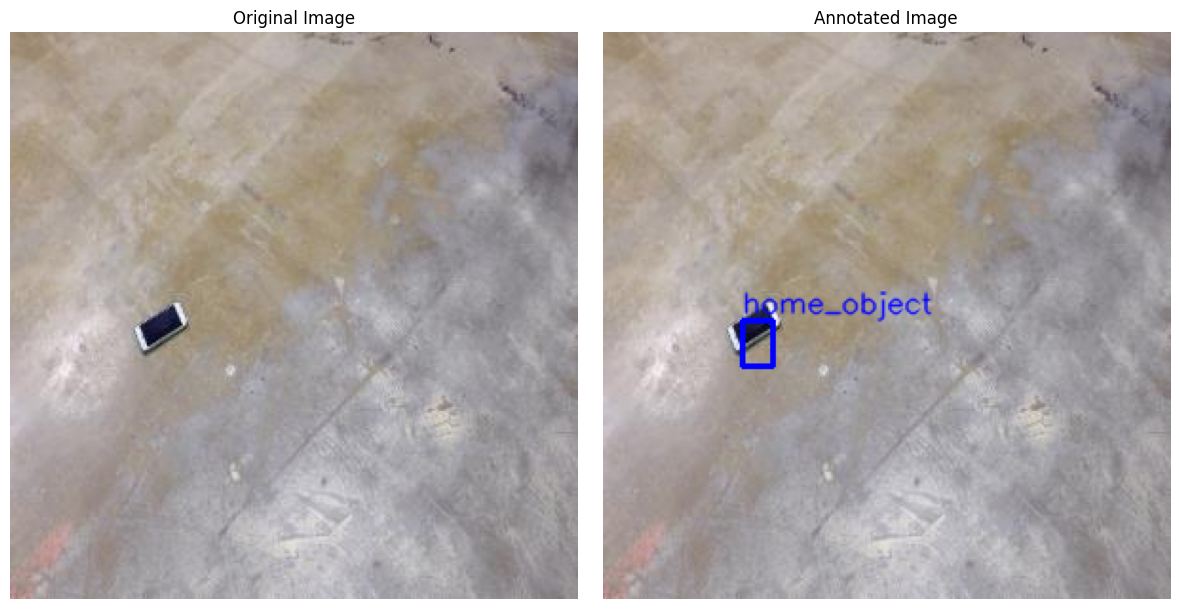

In [34]:
xml_folder_path = '/content/cleaning_bot_object_dataset/xmls'
image_folder_path = '/content/cleaning_bot_object_dataset/images'

predict_random_xml_and_image(xml_folder_path, image_folder_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


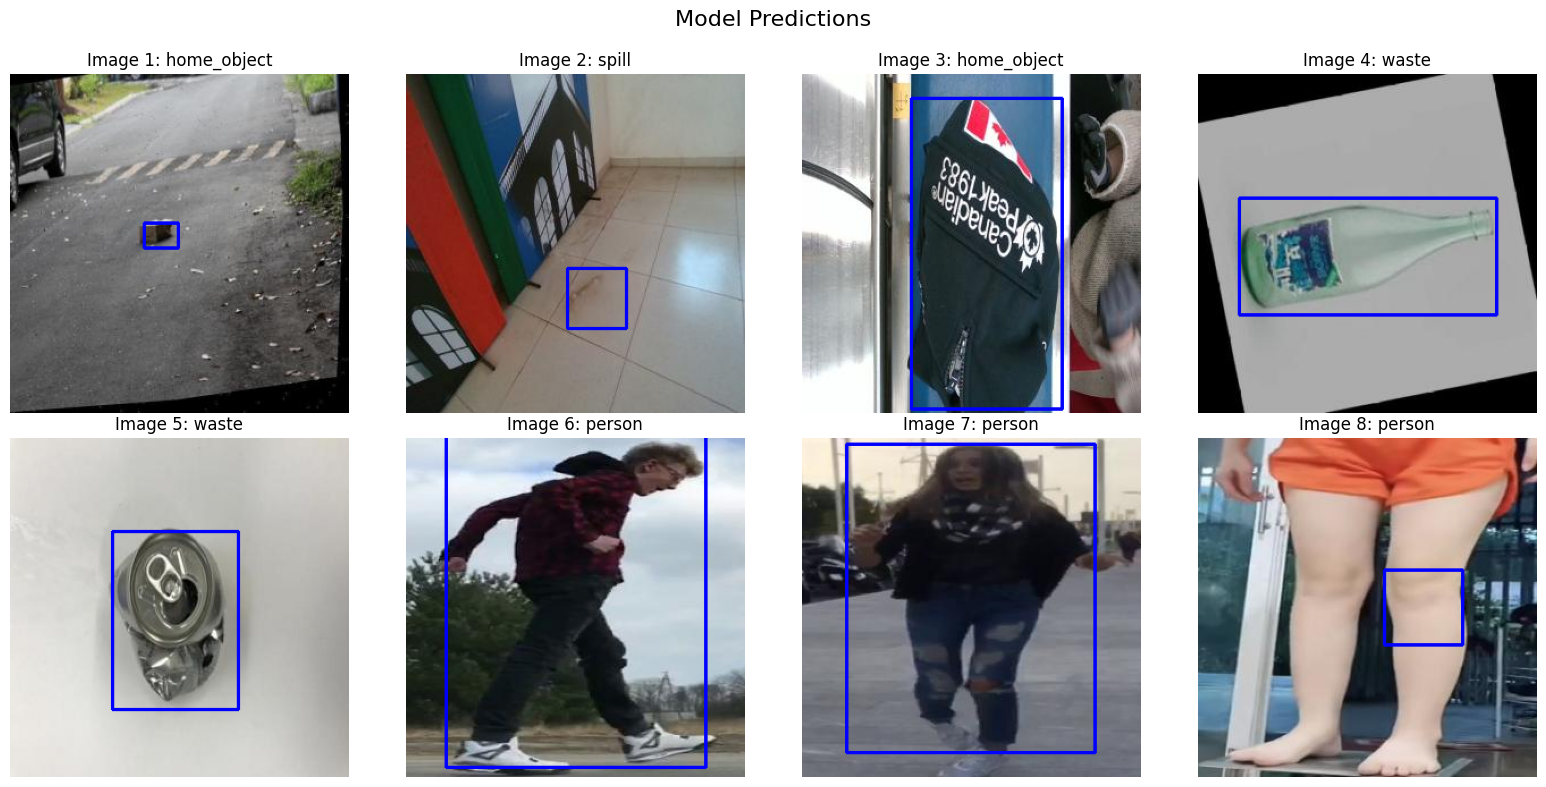

In [37]:
def load_image(path):
    """Load an image from a given path."""
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image from {path}")
    return image

def predict_random_xml_and_image(xml_folder, image_folder, model):
    """
    Selects random XML files from the xml_folder, loads corresponding images from the image_folder,
    and makes predictions using the provided model.

    Args:
    xml_folder: Path to the folder containing XML files.
    image_folder: Path to the folder containing image files.
    model: Pretrained model instance.
    """
    xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

    if not xml_files:
        print("No XML files found in the specified folder.")
        return

    # Choose a random set of 8 XML files
    random_xml_files = random.sample(xml_files, min(8, len(xml_files)))

    images = []
    predictions = []

    for random_xml_file in random_xml_files:
        base_name = os.path.splitext(random_xml_file)[0]
        image_file = os.path.join(image_folder, base_name + '.jpg')

        if not os.path.exists(image_file):
            print(f"Image file not found: {image_file}")
            continue

        image = load_image(image_file)
        images.append(image)

        # Get the model prediction
        annotated_image, prediction = _process_image(image, model)
        predictions.append((annotated_image, prediction))

    # Display images and predictions
    display_predictions(images, predictions)

def _process_image(image, model):
    """Process and predict on the loaded image."""
    image_resized = cv2.resize(image, (299, 299))
    image_array = np.expand_dims(image_resized, axis=0)

    # Get model predictions
    categ, bbox = model.predict(image_array)

    categ_index = np.argmax(categ)

    # Flatten and convert bbox coordinates to integers
    bbox = bbox.flatten().astype(int)

    # Draw bounding box on a copy of the resized image
    image_annotated = cv2.rectangle(image_resized.copy(), (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

    # Get the predicted class label
    prediction = reverse_label_mapping[categ_index]

    return image_annotated, prediction

def display_predictions(images, predictions):
    """Display images with predictions below each image in a grid."""
    # Create a 2x4 grid for 8 images
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Model Predictions', fontsize=16)

    for i, (ax, (img, prediction)) in enumerate(zip(axs.flatten(), predictions), start=1):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        # Set title with image number and prediction
        ax.set_title(f'Image {i}: {prediction}', fontsize=12)

    plt.tight_layout(pad=1.2, h_pad=1)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Define paths
xml_folder_path = '/content/cleaning_bot_object_dataset/xmls'
image_folder_path = '/content/cleaning_bot_object_dataset/images'

# Call the prediction function with the model
predict_random_xml_and_image(xml_folder_path, image_folder_path, model)
